## General Helper Method

In [ ]:
# Import needs
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install catboost scikit-optimize --quiet

     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 100 kB 8.5 MB/s 


In [ ]:
# Load data from drive
def load_data(link, index= None):
  """
  Download data from link id and setting index for dataset index
  """

  # Download data from gdrive
  meta_url = 'https://drive.google.com/uc?export=download&confirm=pbef&id='
  url = meta_url + link
  output = 'data.csv'
  gdown.download(url, output, quiet=True)
  data = pd.read_csv(output)

  # Setting index for dataset
  if index:
    data.set_index(index, inplace=True)

  return data

In [ ]:
# Check data info 
def info_data(data, unique_object=5, unique_number=15):
  """
  Info about data , check the object data with unique > unique_object
  also check the numerical data with unique < unique_number
  """

  # General info about data
  print("Data shape:",data.shape)
  object_data = list(data.select_dtypes(include= 'object').columns)
  num_data = list(data.select_dtypes(exclude= 'object').columns)
  print('Total categorical:', len(object_data))
  print('Total numerical:', len(num_data),'\n')
  
  # Info for object columns
  if object_data:
    many_unique = [x for x in object_data if (data[x].nunique() > unique_object or data[x].nunique()==1)]
    print(f'Categorical with >{unique_object} or 1 unique:', len(many_unique), '\n')
    print(data[many_unique].nunique().sort_values(),'\n')

  # Info for number columns
  few_unique = [x for x in num_data if data[x].nunique() < unique_number]
  print(f'Numerical with <{unique_number} unique:', len(few_unique), '\n')
  print(data[few_unique].nunique().sort_values())

In [ ]:
# Check missing value
def missing_data(data, null_percentage=25):
  """
  Check missing data, also data with missing value > null_percentage %
  """

  # Check total missing value
  null = data.isnull().sum()
  print(f"Missing columns total: {(null!=0).sum()}/{len(data.columns)}")
  print("Missing columns name:", ', '.join([x for x in data.columns if data[x].isnull().any()]))

  # Check value with many missing
  over_percentage = null[null > (null_percentage/100*data.shape[0])]
  print(f"Null columns over {null_percentage}% data:", over_percentage.shape[0],'\n')
  print(over_percentage.sort_values())

In [ ]:
# Plot missing value
def plot_missing_data(data):
  """
  Heatmap missing data
  """
  plt.figure(figsize=(10,10))
  return px.imshow(data.isnull()/1,  width=600, height=400,
                   title ="Missing Value")

In [ ]:
# Plot missing value
def plot_correlation(data, start=0, end=None, annot=False):
  """
  Plot independent data correlation from index columns start until end
  """

  if end == None:
      end = data.shape[1]
  num_data = (data.select_dtypes(include= 'number')).iloc[:,start:end]
  plt.figure(figsize=(10,7))
  
  # Plot correlation with heatmap
  sns.heatmap(num_data.corr(),cmap=plt.cm.Reds,annot=annot, fmt='.2f')
  plt.title('Data Correlation',fontsize=20)
  plt.xticks(rotation=20)
  plt.show()

In [ ]:
# Check skewness on data
def plot_skew(data):
  """
  Bar plot skewness of numerical data
  """
  plt.figure(figsize=(10,8))
  num = data.select_dtypes("number")
  skew_feats = num.skew().sort_values(ascending=False)
  skew_feats = pd.DataFrame(skew_feats, columns=["Skewed"]).reset_index()
  sns.barplot(x=skew_feats.Skewed, y=skew_feats["index"])
  plt.title('Skewed Data')

In [ ]:
def lineplot_data(time, col, data):
  """
  Show trend data with between time and each col
  """
  plt.style.use('ggplot')
  fig , ax = plt.subplots(math.ceil(len(col)/2), 2, figsize=(15,len(col)*1.8))
  idx=0
  for row in ax:
    for column in row:
      sns.lineplot(data[time], data[col[idx]], ax=column, palette='g')
      plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
      column.set_ylabel(column.get_ylabel(), fontsize=10)
      idx+=1
      if idx >= len(col): break
  plt.suptitle('Line Plot', y=1.04, fontsize=20)
  plt.tight_layout()

In [ ]:
# Pairplot data

def pairplot_data(data, start=0, end=None, hue=None):
  """
  Show pairplot data with columns on index start until end
  """
  if end==None:
    end = data.shape[1]
  
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  if hue.any():
    temp_data = pd.concat([data.select_dtypes('number').iloc[:,start:end], pd.DataFrame(hue, columns=["Hue"])], axis=1)
    sns.pairplot(temp_data,hue="Hue", diag_kind='kde',palette='Set2')
  else:
    temp_data = data.select_dtypes('number').iloc[:,start:end]
    sns.pairplot(temp_data, diag_kind='kde',palette='Set2')

In [ ]:
# Distribution plot data
def dist_data(train_data, test_data=None, dtype='number', start=0, end=None,
              unique_object=8, compare=False):
  """
  Plot distribution numerical data if dtype == "number" with distplot
  Plot distribution of categorical data with unique < unique_object if dtype=='object' with countplot
  If compare True then compare distribution train and test
  """
  if end == None:
      end = train_data.shape[1]

  # Checking for numerical distrbution or categorical
  if dtype == 'number':
    type_data = list(train_data.select_dtypes(include= 'number').columns)[start:end]
    plot = sns.distplot
  elif dtype=='object':
    object_data = list(train_data.select_dtypes(include= 'object').columns)
    type_data = [x for x in object_data if train_data[x].nunique() <= unique_object][start:end]
    plot = sns.countplot 
  shapes = len(type_data)

  # Comparing distribution with test set
  if compare:
    fig , ax = plt.subplots(shapes, 2, figsize=(10,shapes*3))
    flag = True
    for i,j in zip(type_data , ax):
      try:
        plot(train_data[i], ax=j[0], color="g")
        plot(test_data[i], ax=j[1], color="g")        
      except:
        plot(train_data[i], ax=j[0], palette='mako')
        plot(test_data[i], ax=j[1], palette='mako')
      if flag:
        j[0].set_title('Train Data', fontsize=18)
        j[1].set_title('Test Data', fontsize=18)
        flag = False

      j[0].get_xaxis().set_visible(False)
      j[0].get_yaxis().set_visible(False)
      j[1].get_xaxis().set_visible(False)
      j[1].get_yaxis().set_visible(False)
      j[0].text(0.5, -0.06, i, horizontalalignment='center',
            verticalalignment='center', transform=j[0].transAxes)
      j[1].text(0.5, -0.06, i, horizontalalignment='center',
            verticalalignment='center', transform=j[1].transAxes)
  
  # Not comparing distribution 
  else:
    fig , ax = plt.subplots(math.ceil(shapes/3), 3, figsize=(20,shapes*3))
    if ax.ndim==1: ax = [ax]

    idx=0
    for row in ax:
      for column in row:
        try:
          plot(train_data[type_data[idx]], ax=column, palette='mako')
        except:
          plot(train_data[type_data[idx]], ax=column, color="g")
        xlabels = column.get_xticklabels()
        column.set_xticklabels(xlabels, rotation=25, ha='right')
        idx+=1
        if idx >= shapes: break

  plt.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle("Data Distribution", fontsize=20, y=1.05)

In [ ]:
# Scatter features vs target
def scatter_target(data, target, start=0, end=None):
  """
  Scatter independent variabel with target on regression task
  """
  if end == None:
    end = data.shape[1]
  num_data = list(data.select_dtypes(include= 'number').columns)[start:end]

  fig , ax = plt.subplots(math.ceil(len(num_data)/3), 3, figsize=(15,10))
  idx=0
  for row in ax:
    for column in row:
      sns.scatterplot(data[num_data[idx]], target, ax=column)
      idx+=1
      if idx >= len(num_data): break

  plt.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle("Target relationship", fontsize=20)

In [ ]:
# Plot categorical vs numerical data
def cat_vs_num(data, categoric, start=0, end=None, kind='Violin'):
  """
  Plot categorical vs numerical with categoric column.
  There are 3 types: "Violin" or "Box" or "Catplot"
  """

  end = data.shape[1] if end==None else end
  palette = 'magma' if categoric==None else 'mako'

  type_data = list(data.select_dtypes(include= 'number').columns)[start:end]

  # Adjust figure
  fig , ax = plt.subplots(math.ceil(len(type_data)/3), 3, figsize=(20,end*1.2))
  if ax.ndim==1: ax = [ax]
   
  # Kind of plot
  if kind=='Violinplot':
    plot = sns.violinplot
  elif kind=='Catplot':
    plot = sns.catplot
  elif kind=="Boxplot": 
    plot = sns.boxplot

  # Plotting
  idx=0
  for row in ax:
    for column in row:
      plot(categoric, type_data[idx], data=data, ax=column, palette=palette)
      idx+=1
      if idx >= len(type_data): break

  plt.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle(f"{kind} Plot", fontsize=20)

In [ ]:
# Compare 2 boxplot 
def compare_boxplot(train_data, test_data=None, start=0, end=None):
  """
  Compare boxplot from train data with test data
  """

  if end == None:
      end = train_data.shape[1]

  type_data = list(train_data.select_dtypes(include= 'number').columns)[start:end]

  # Plotting
  fig , ax = plt.subplots(len(type_data), 2, figsize=(15,end*1.3))
  flag = True
  for i,j in zip(type_data , ax):
    sns.boxplot(train_data[i], ax=j[0], color='m')
    sns.boxplot(test_data[i], ax=j[1], color='c')        
    
    if flag:
      j[0].set_title('Train Data', fontsize=18)
      j[1].set_title('Test Data', fontsize=18)
      flag = False
  plt.tight_layout()

In [ ]:
# Plot correlation with target
def corr_target(data, target):
  """
  Plot correlation between data and target with barplot
  """ 
  
  plt.style.use('ggplot')
  plt.figure(figsize=(12,10))
  cor = data.corr()[target].sort_values(ascending=False).iloc[1:].reset_index()
  sns.barplot(target,'index',data=cor);

In [ ]:
from sklearn.feature_selection import chi2

# Chi test (cat vs cat)
def chi_test(data1, data2):
  """
  Chi test to find correlation between 
  """
  cat1 = pd.factorize(data1)[0]
  cat2 = pd.factorize(data2)[0]

  chi2_val, p_val = chi2(np.array(cat1).reshape(-1, 1), np.array(cat2).reshape(-1, 1))
  if p_val==0:
    test = "No correlated at all"
  elif p_val <0.05:
    test = 'significantly correlated'
  else:
    test = 'unsignificantly correlated'
  print(f'P value for {data1.name} and {data2.name} : {p_val[0]:e} ({test})')

In [ ]:
# Drop column
def drop_data(data, column):
  """
  Drop column in data
  """
  data = data.copy()
  data.drop(column, axis=1, inplace=True)
  return data

**Data Preparation**:
* load_data : load data from link
* info_data : info about data
* missing_data : check missing data
* plot_missing_data : plot missing data

**EDA**

* lineplot_data : lineplot between time and col
* pairplot_data : pairplot among features
* dist_data : check distribution on data (can compare with test)
* scatter_target : scatter features with target (regression)
* cat_vs_num : check box/violin/catplot for target vs features
* compare_boxplot : compare boxplot on train and test
* corr_target : correlation feature with target

**Data Manipulation**
* plot_correlation : plot correlation among features
* plot_skew : plot skewness of features
* chi_test : check correlated significance between categorical data
* drop_data : drop data

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
def split_data(data, target, size=0.25, output=True):
  data_train, data_val, target_train, target_val = train_test_split(data, target, test_size=size, random_state=42)
  if output:
    print("data_train shape:", data_train.shape)
    print("data_val shape:", data_val.shape)

  data_train = pd.DataFrame(data_train, columns=data_train.columns, index=data_train.index)
  data_test = pd.DataFrame(data_val, columns=data_val.columns, index=data_val.index)
  return data_train, data_val, target_train, target_val

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Encode categorical data
def encode_data(data, train_data, ordinal=None, onehot=None):
  data = data.copy()

  # For ordinal encode
  if ordinal:
    ordinal_data = data[ordinal]
    ord = OrdinalEncoder()
    ord.fit(ordinal_data)
    data[ordinal] = ord.transform(data[ordinal])

  # For one hot encode
  if onehot:
    onehot_data = data[onehot]
    hot  = OneHotEncoder(sparse=False, drop='first')
    hot.fit(onehot_data)
    
    col = []
    for x in onehot:
      for i in range(1,data[x].nunique()):
        col.append(f'{x}_{i}')

    data[col] = hot.transform(data[onehot]) 
    data.drop(onehot, axis=1, inplace=True)

  return data

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Impute missing value
def impute_data(data, train_data):
  num_data = data.select_dtypes(exclude='object')
  cat_data = data.select_dtypes(include='object')
  num_train_data = train_data.select_dtypes(exclude='object')
  imputer = IterativeImputer()
  imputer.fit(num_train_data)
  impute_data = pd.DataFrame(imputer.transform(num_data), columns = num_data.columns,
                            index = num_data.index)
  print('Total missing numerical value after impute:', impute_data.isnull().sum().sum())
  impute_data = pd.concat([impute_data, cat_data], axis=1)
  impute_data = impute_data.reindex(columns=data.columns)
  print('Total remaining missing data:', (impute_data.isnull().sum(axis=1)>0).sum())
  return impute_data

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standard scaling data
def scale_data(data, train_data, exclude=None):
  # Excluding columns for scaling
  if exclude:
    separate_data = data[exclude]
    toscale_data = drop_data(data, exclude)
    toscale_train = drop_data(train_data, exclude)
  else:
    toscale_data, toscale_train = data.copy(), train_data.copy()

  # Scaling data
  scaler = StandardScaler()
  scaler.fit(toscale_train)
  temp_data = pd.DataFrame(scaler.transform(toscale_data), columns=toscale_data.columns, 
                           index=data.index)
  
  if exclude:
      return pd.concat([temp_data, separate_data], axis=1).reindex(columns = data.columns)
  return temp_data

In [ ]:
from scipy.stats import boxcox

# transform data
def transform_data(data, kind="boxcox",addition=0.01):
  num = data.select_dtypes("number")
  if kind=="boxcox":
    for i in num.columns:
      num[i], _ = boxcox(num[i]+addition, lmbda=None)
  elif kind=='sqrt':
    num = np.sqrt(num)
  elif kind=='log':
    num = np.log(num)
  return num

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

# Search classification model
def search_clf_model(X, y, score='accuracy', name = 'accuracy'):
  models = {'RFC': RandomForestClassifier(random_state=1), 'XGB': XGBClassifier(random_state=1), 'AdaBoost': AdaBoostClassifier(random_state=1),
            'SVC': SVC(random_state=1), 'NaiveBayes': GaussianNB(), 'CatBoost': CatBoostClassifier(random_state=1, silent=True),
            'GBC': GradientBoostingClassifier(random_state=1), 'LogReg': LogisticRegression(random_state=1), 'KNN': KNeighborsClassifier()}

  for mdl in models.keys():

    model = models[mdl]
    val_score = cross_val_score(model,X, y, scoring=score, cv=5)
    print(f'{mdl} {name}:', np.mean(val_score))

In [ ]:
import xgboost
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import loguniform 

# Hyperparameter tuning model
def tuning_model(model, X, y, score='accuracy', n_iter=50):
  models = {'RFC': RandomForestClassifier(), 'XGB': XGBClassifier(), 'CatBoost': CatBoostClassifier(),
            'KNN': KNeighborsClassifier(), 'AdaBoost': AdaBoostClassifier(), 'NaiveBayes': GaussianNB(),
            'GBC': GradientBoostingClassifier(), 'LogReg': LogisticRegression(), 'SVC': SVC()}

  hyperparameter = {'RFC': { 'max_depth': Integer(5,25), 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': Integer(2,10),
                            'min_samples_split': Integer(2,10), 'n_estimators': Integer(100,200), 'random_state':[1]},
                    'XGB': {'learning_rate': [loguniform.rvs(1e-3,5e-1)], 'max_depth': Integer(5,25), 'min_child_weight': Integer(1,8),
                            'subsample': Real(0.4, 1), 'colsample_bytree': Real(0.5, 0.7), 'n_estimators' : Integer(40,160), 'random_state':[1]},
                    'CatBoost': {'max_depth': Integer(5,15), 'n_estimators':Integer(40,160),
                                "learning_rate": [loguniform.rvs(1e-3,5e-1)], 'silent':[True], 'random_state':[1]},
                    'LogReg': {'C': np.logspace(-4,4,20), 'penalty' : ['l1', 'l2'], 'random_state':[1]}}

  for mdl in model:
    opt = BayesSearchCV(models[mdl], hyperparameter[mdl], n_iter=n_iter,
                        random_state=0, verbose=0, cv=5)
    opt.fit(X, y)
    print(f'{mdl} best score: {opt.best_score_}')
    print(f'{mdl} best params: {opt.best_params_}')
    
    val_score = cross_val_score(opt.best_estimator_ , X, y, scoring=score, cv=5)
    print(f'{mdl} {score}:', np.mean(val_score))

In [ ]:
# Callback function
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

# Callback for plotting loss
tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=1,
                            write_graph=True, write_images=True)

# Callback for reducing learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'loss', 
    factor = 0.5,   
    patience = 20, 
    verbose = 1)

In [ ]:
from keras import backend as K
# Stackoverflow references
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow import keras
import tensorflow as tf

# Deep neural network model
def dnn(X, y, output, epoch=200):
  regularizer = keras.regularizers.l2(0.001)
  dummy_y = tf.keras.utils.to_categorical(y)
  dnn_model = tf.keras.Sequential([
      keras.layers.Input(shape=(X.shape[-1],)),
      keras.layers.Dense(64, 
                        kernel_regularizer = regularizer,
                        bias_regularizer = regularizer,
                        activation = 'relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(32, 
                        kernel_regularizer = regularizer,
                        bias_regularizer = regularizer,
                        activation = 'relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(16, 
                        kernel_regularizer = regularizer,
                        bias_regularizer = regularizer,
                        activation = 'relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(units = output,
                         activation='softmax',
                         kernel_regularizer = regularizer,
                         bias_regularizer = regularizer)])
                         

  loss_func = 'binary_crossentropy' if output==2 else 'categorical_crossentropy'

  # Compiling the model
  dnn_model.compile(
      optimizer = tf.optimizers.Adam(learning_rate = 0.01),
      loss = loss_func,
      metrics = F1)

  # Fitting
  history = dnn_model.fit(X, dummy_y, epochs = epoch, \
                          verbose = 1, validation_split = 0.2,
                          callbacks=[reduce_lr, tensor_board])
  return dnn_model

In [ ]:
# Self defined f1 metric
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

def func(y_true, y_predicted):
    score = np.mean(f1_score(y_true, y_predicted, average='macro'))
    return score
    
f1 = make_scorer(func, greater_is_better=True)

In [ ]:
# Predict data
def predict_data(model, data_train, target_train, data_val=[None], target_val=[None], score=True):
  # If want to see the validation score
  if score:
    val_score = cross_val_score(model, data_train, target_train, cv=5, scoring=f1)
    print(f'val score: {np.mean(val_score)}, val std: {np.std(val_score)}')
  
  if all(data_val):
    model.fit(data_train, target_train)
    if score:
      print('test score:',f1_score(model.predict(data_val), target_val, average='macro'))
    return model.predict(data_val)

In [ ]:
# Submission result
def submission(id, data, target, pred):  
  output = pd.DataFrame({id: data[id], 
                        target: pred })
  output.to_csv('submission.csv', index=False)
  return output

## Prepare Data

In [ ]:
# Load data
train_df = load_data('1KAs-UUmt8kAMc2j8nelCX92IDveYhTOd')
test_df = load_data('1OHMh7ypn0Q1vTRg4RDJecpJEWjr70xfh')

In [ ]:
train_df.head(2)

show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   

                                         listed_in  \
0                                    Documentaries   
1  International TV Shows, TV Dramas, TV Mysteries   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...

In [ ]:
test_df.head(2)

id                  played_at  \
0  486d95087ff4445da692067dfdbd3870  2021-10-07 00:34:51+00:00   
1  2de9f70785c848f8bb580f188c4f0302  2021-10-09 01:04:58+00:00   

          tournament                  map  game_length  winner  \
0  DH Masters Winter  2000 Atmospheres LE         1046       1   
1  DH Masters Winter        Lightshade LE         1159       2   

   p1_max_collection_rate  p2_max_collection_rate  p1_apm  p2_apm  ...  \
0                    4630                    4316     366     324  ...   
1                    4036                    3857     327     443  ...   

   p2_minerals_lost  p2_minerals_collected  p1_avg_collection_rate_gas  \
0             18700                  37425                       747.0   
1             16600                  37555                       525.3   

   p1_avg_unspent_gas  p1_gas_lost  p1_gas_collected  \
0               362.2         6000             10912   
1               272.4         4250              8616   

   p2_avg_collection_rate_gas  p2_avg_unspent_gas  p2_gas_lost  \
0                       684.0               458.7         6925   
1                       456.0               306.2         3350   

   p2_gas_collected  
0             10821  
1              7502  

[2 rows x 46 columns]

In [ ]:
# Create target
target = train_df['matchup'].replace(['PvP', 'PvZ', 'TvP', 'TvT', 'TvZ', 'ZvZ'], list(range(6)))

## EDA

### 1. Info about train and test

There are some unimportant features such as played at and id because there are too many unique values, but we'll do research furthermore

In [ ]:
info_data(train_df)

Data shape: (829, 49)
Total categorical: 7
Total numerical: 42 

Categorical with >5 or 1 unique: 4 

matchup        6
map           46
played_at    828
id           829
dtype: int64 

Numerical with <15 unique: 1 

winner    2
dtype: int64 



In [ ]:
info_data(test_df)

Data shape: (554, 46)
Total categorical: 4
Total numerical: 42 

Categorical with >5 or 1 unique: 3 

map           39
id           554
played_at    554
dtype: int64 

Numerical with <15 unique: 1 

winner    2
dtype: int64 



### 2. Missing value

There are no missing values in the dataset

In [ ]:
missing_data(train_df)

Missing columns total: 0/49
Missing columns name: 
Null columns over 25% data: 0 

Series([], dtype: int64)


In [ ]:
missing_data(test_df)

Missing columns total: 0/46
Missing columns name: 
Null columns over 25% data: 0 

Series([], dtype: int64)


In [ ]:
plot_missing_data(train_df)

<Figure size 720x720 with 0 Axes>

### 3. Data distribution (Univariate Analysis)

There are some distributions that are skewed, need to be standardize for improving model performance

The train and test distribution is not too different. Trian validation score should'nt be really different from test. 

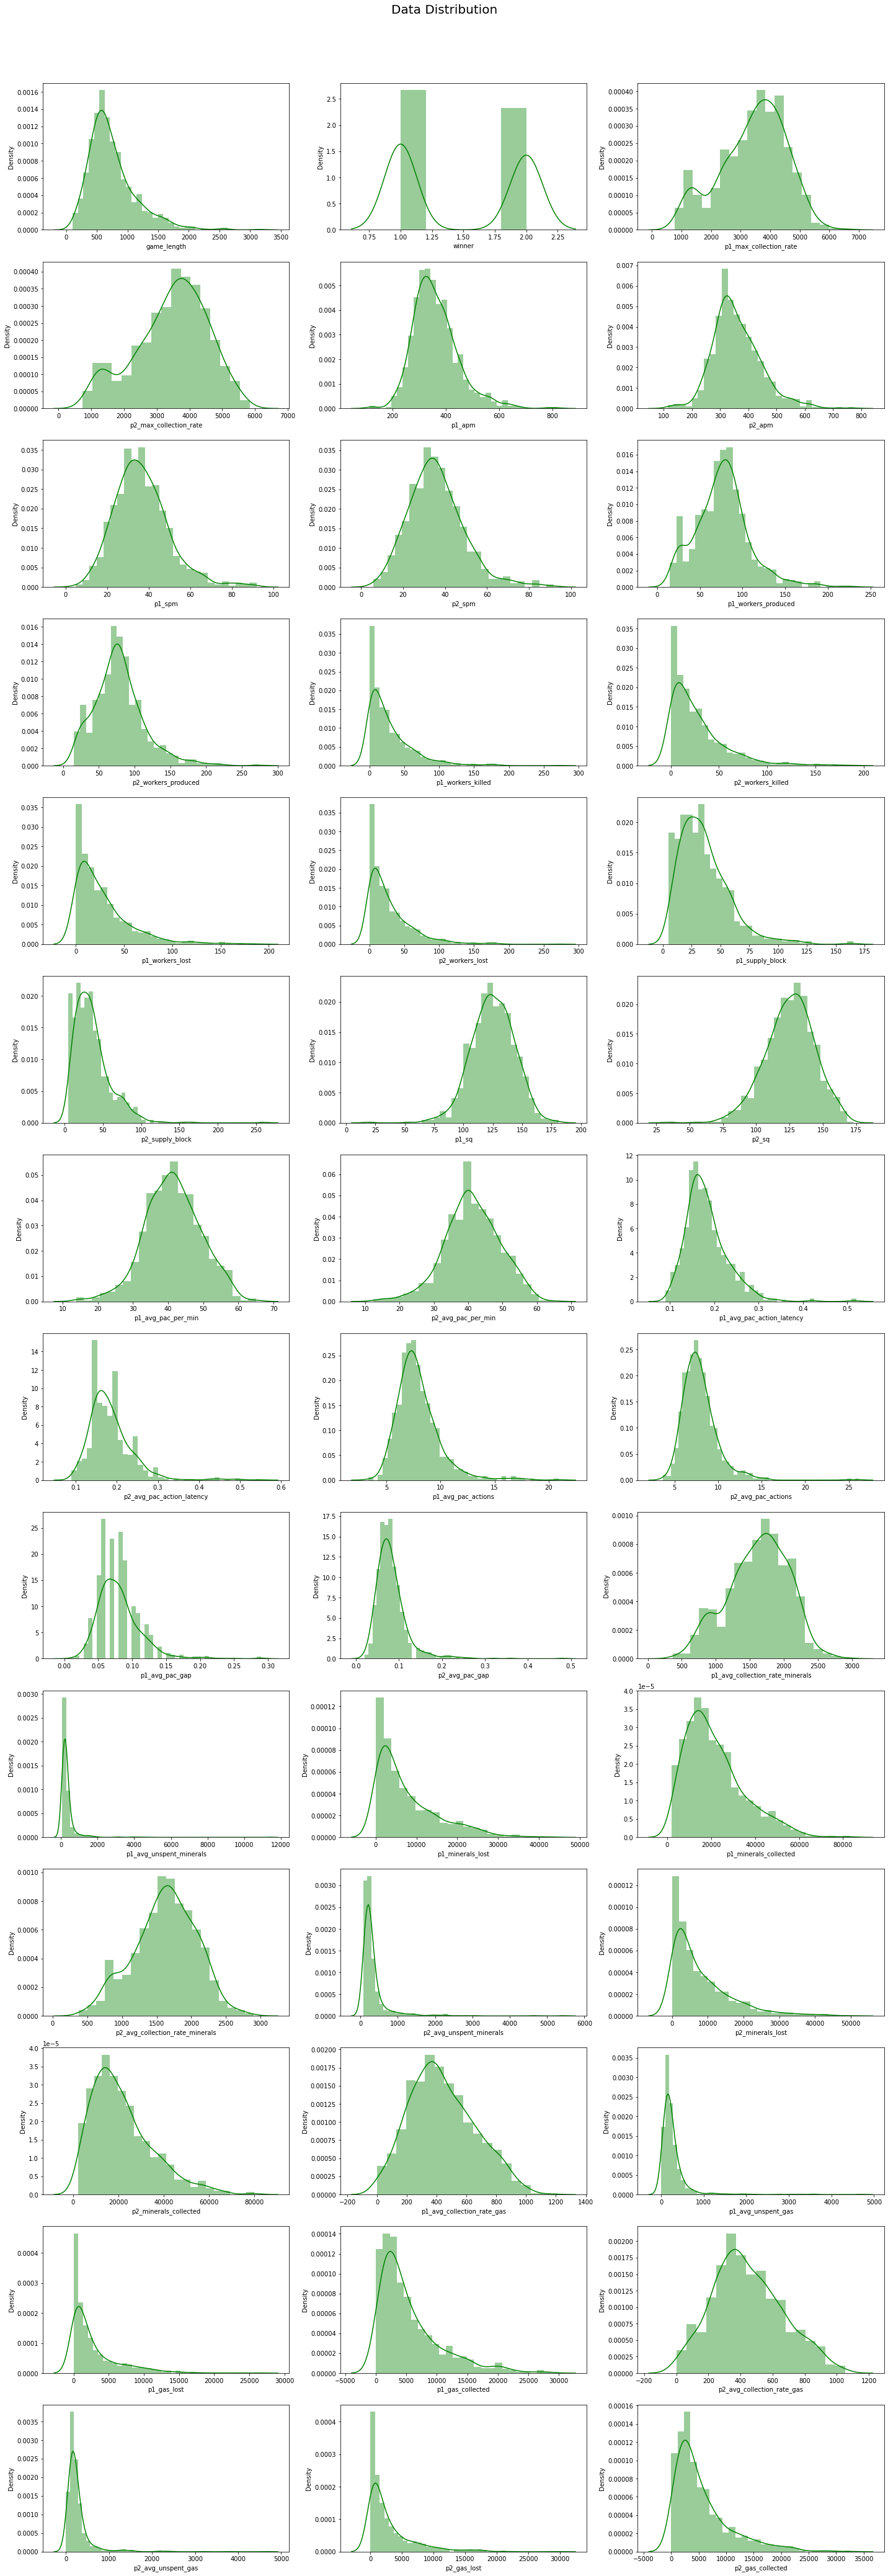

In [ ]:
# Distribution of numerical variable
dist_data(train_df,compare=False, max_number=None)

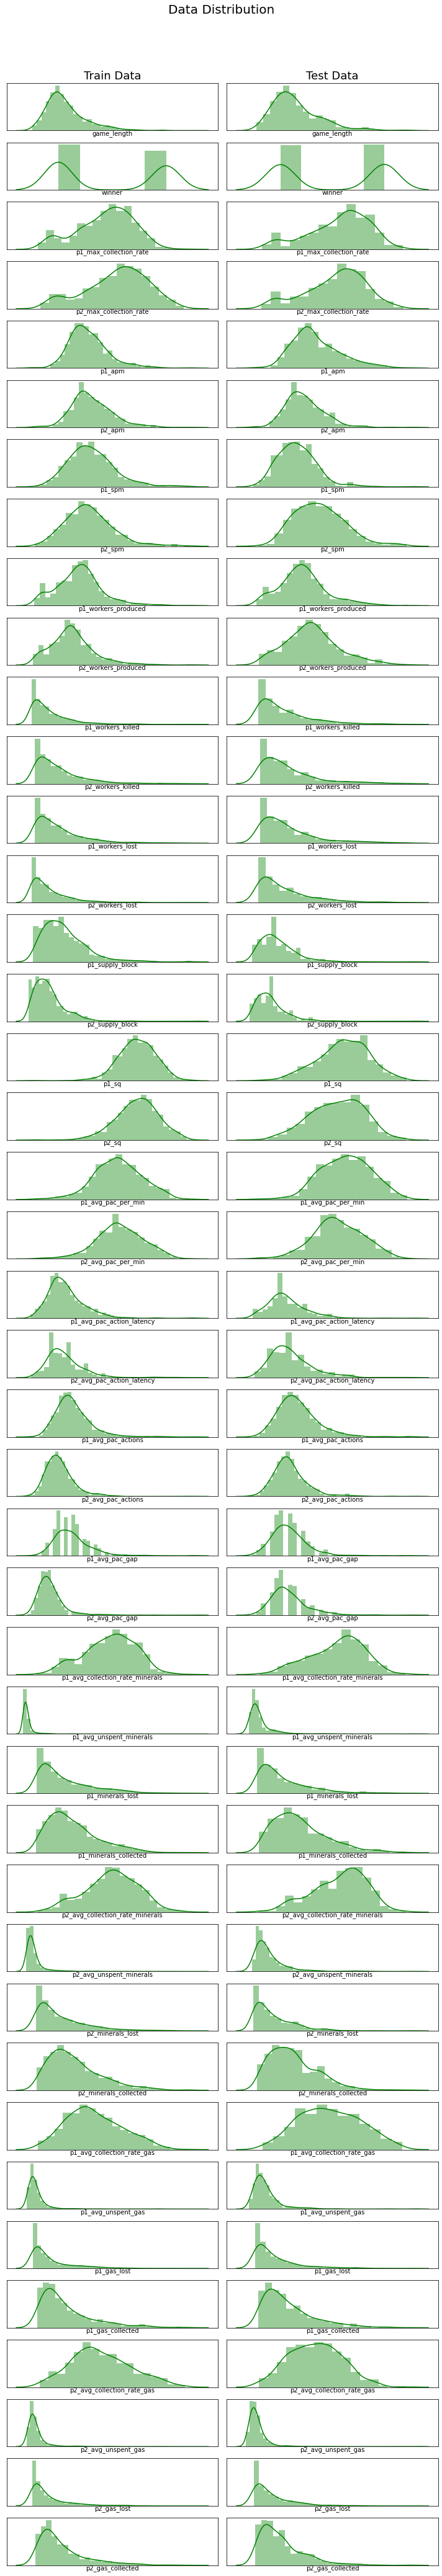

In [ ]:
# Compare distribution of numerical variable train and test
dist_data(train_df, test_df, compare=True, max_number=None)

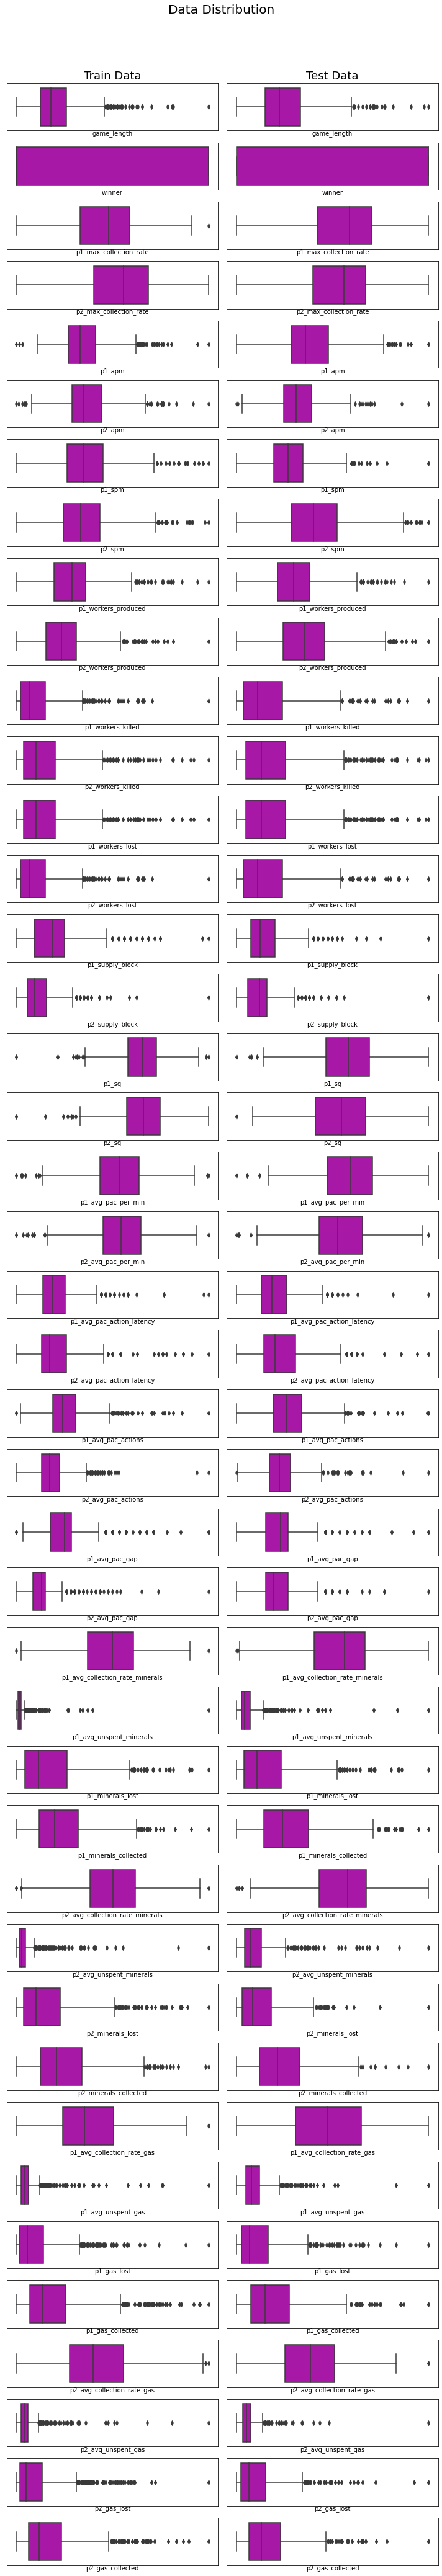

In [ ]:
# Compare boxplot of numerical variable train and test
dist_data(train_df, test_df, kind='box', compare=True, max_number=None, color='m')

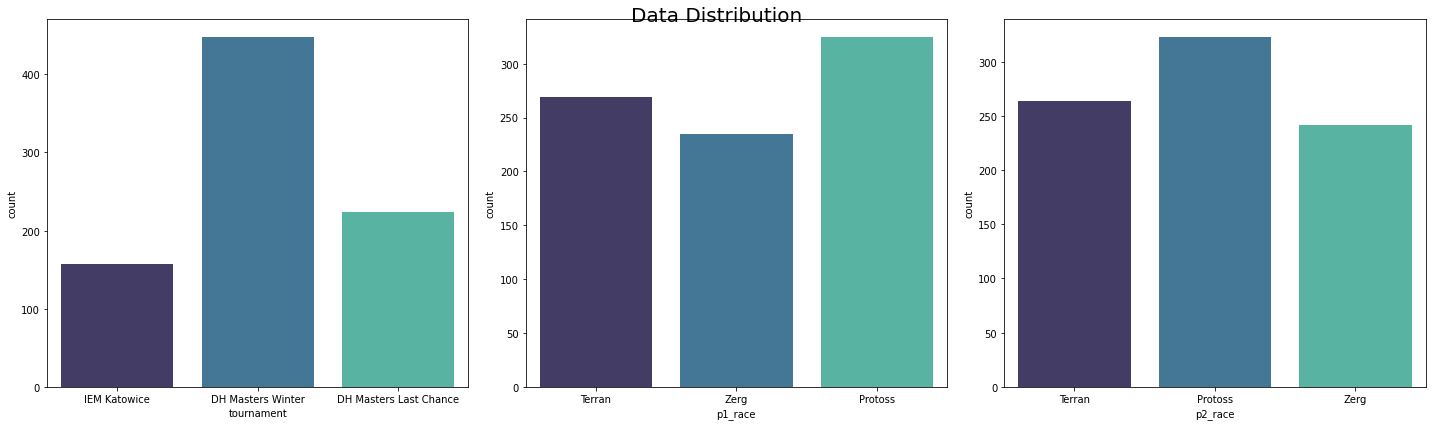

In [ ]:
# Distribution of categorical variable
dist_data(train_df, compare=False, dtype='object', max_number=5)

### 4. Correlation between features

There are some multicolinearity , and columns that are 100% percent correlated (need to be researched)

The same features for p1 and p2 are highly correlated (maybe stacking could improve performances)

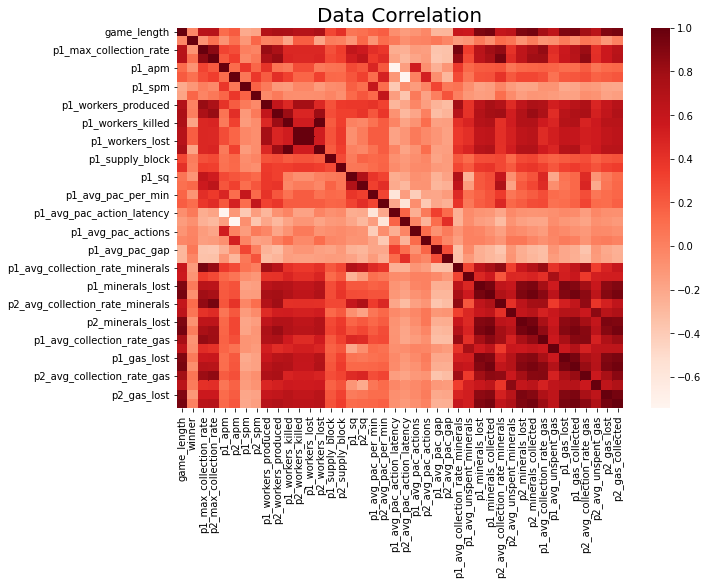

In [ ]:
# Correlation between features
plot_correlation(train_df)

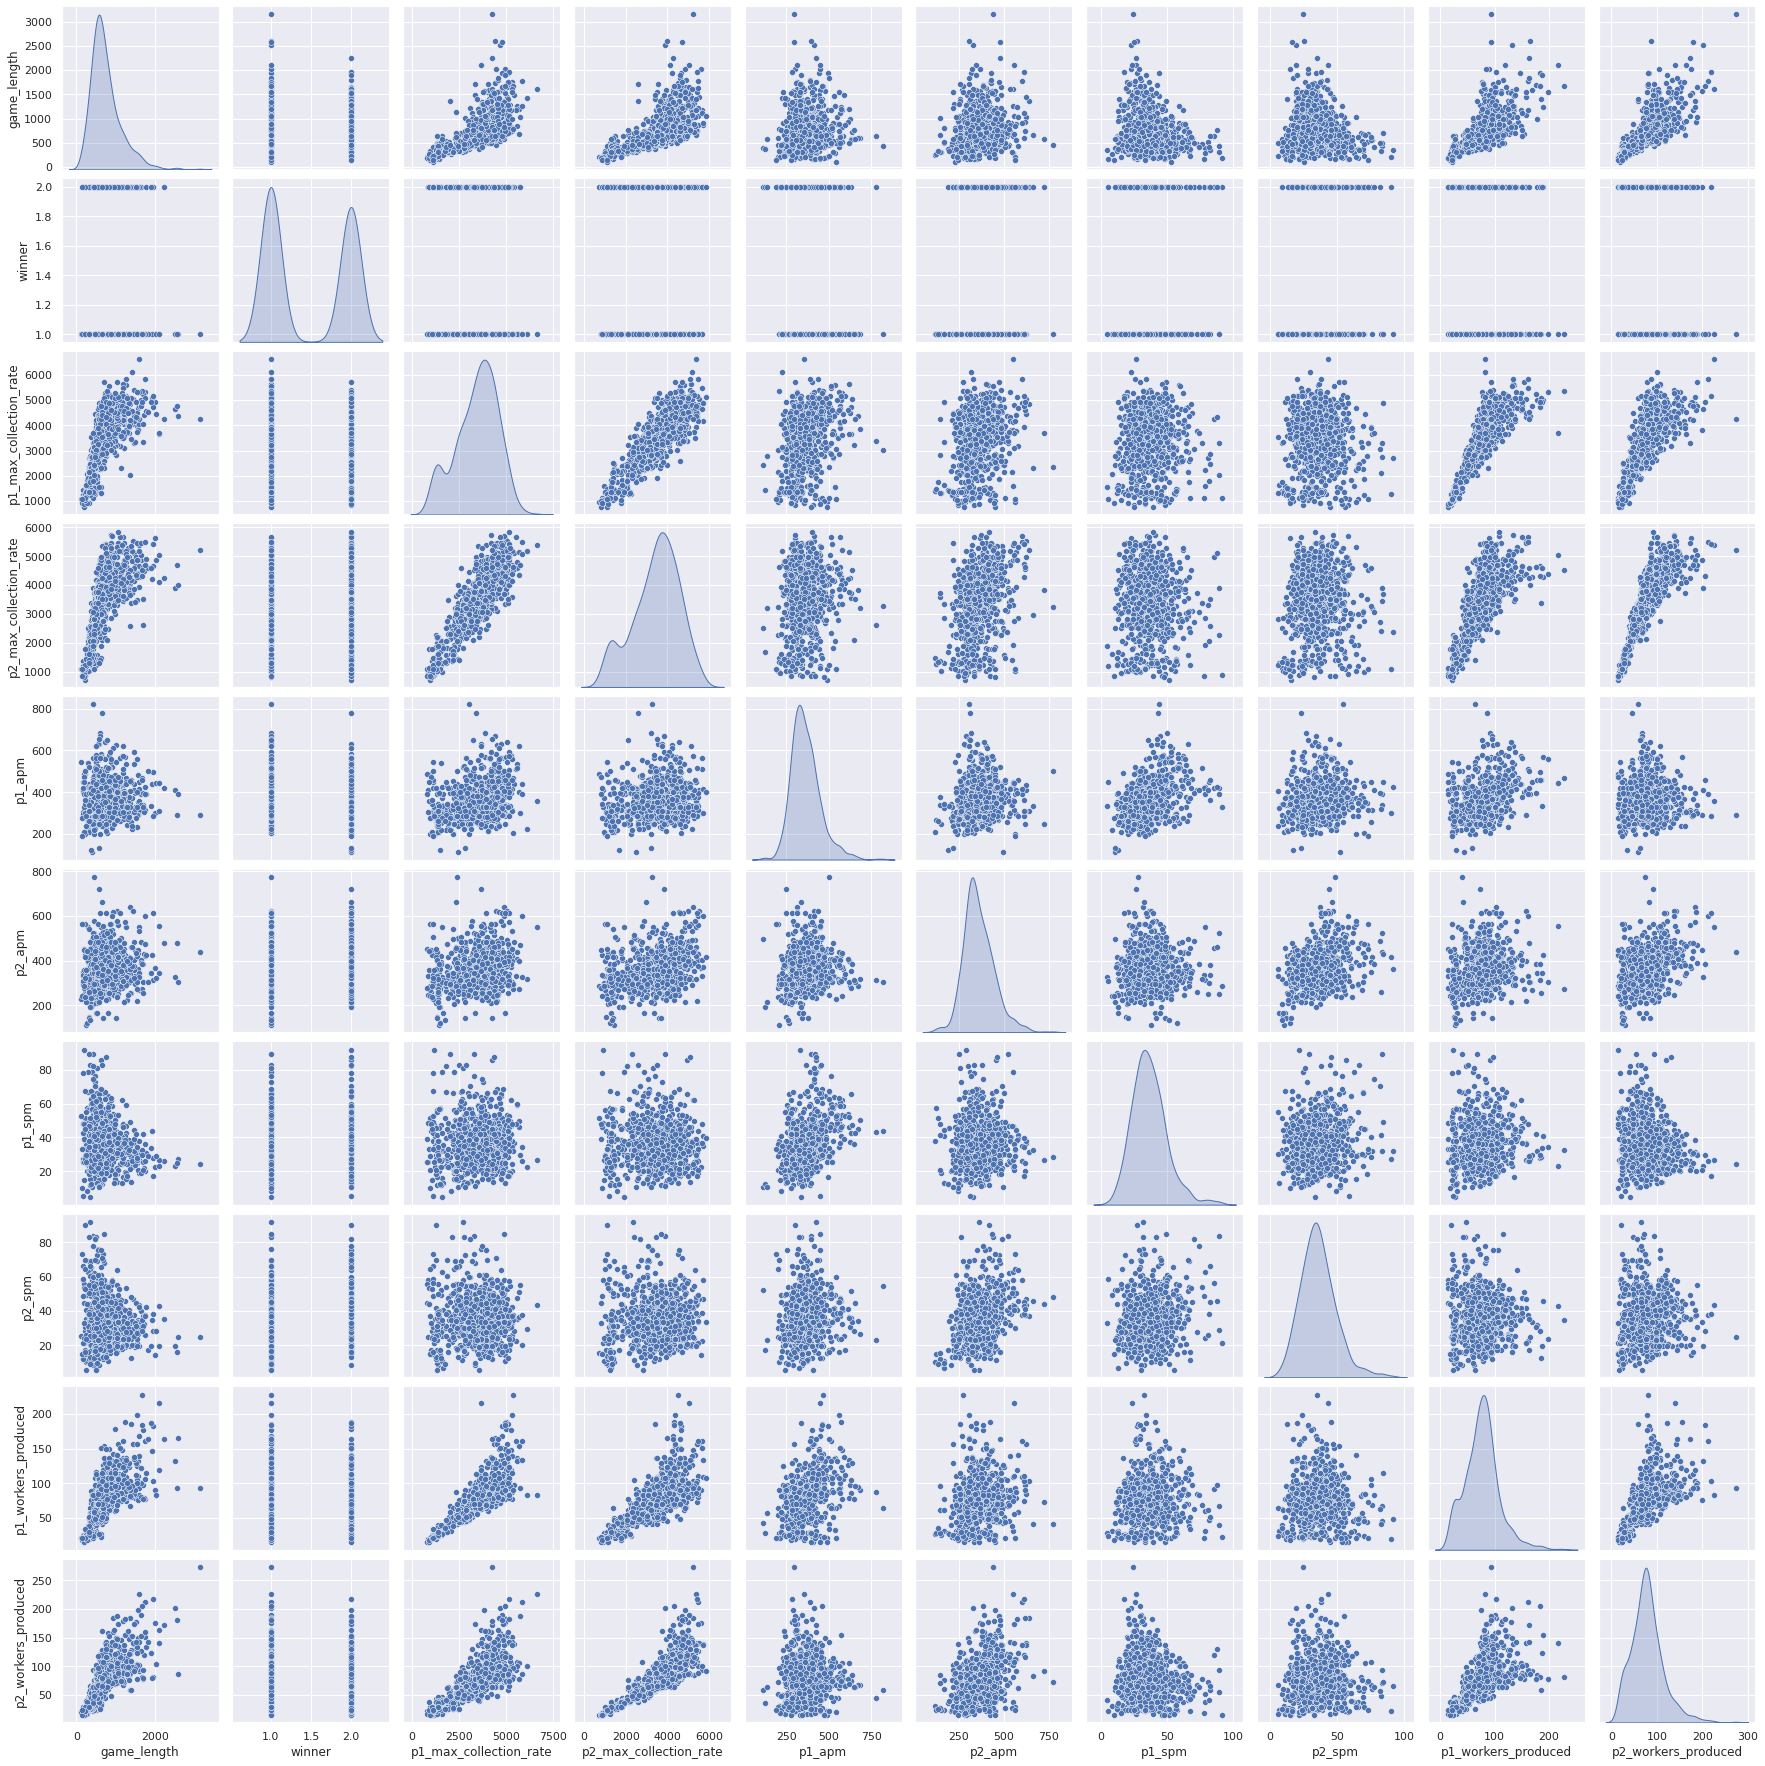

In [ ]:
# Pairplot between features
pairplot_data(train_df, 'matchup', number_pair = 10)

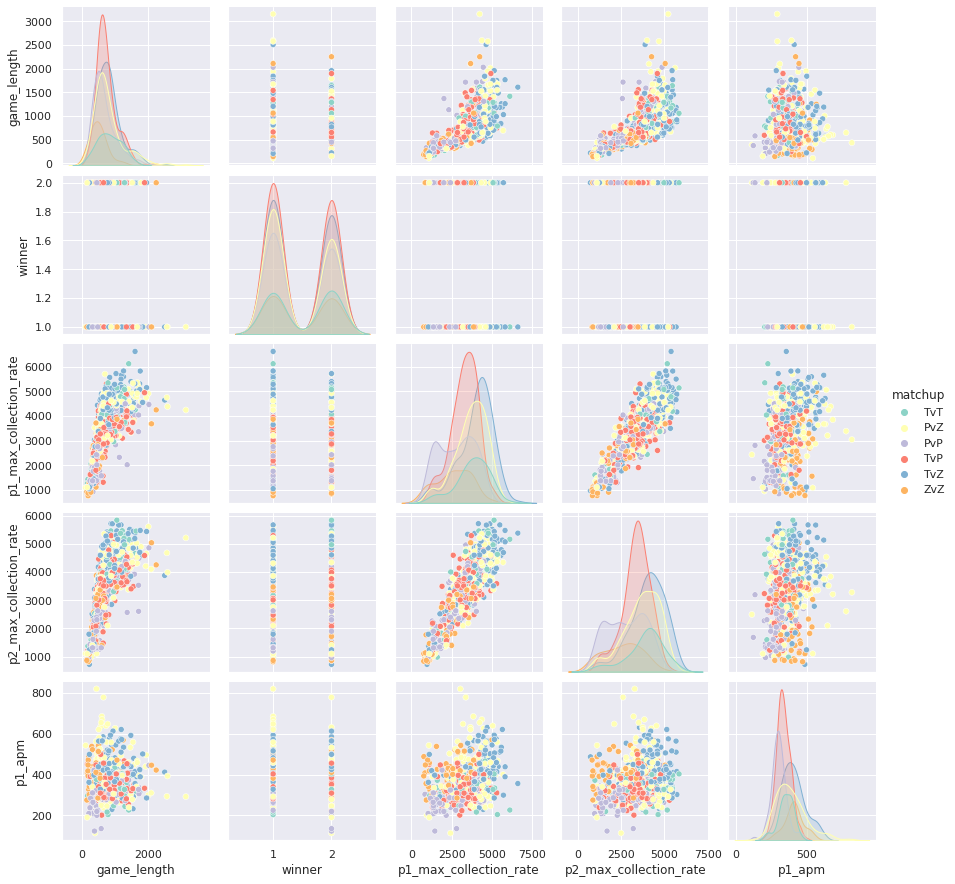

In [ ]:
# Pairplot between features on target
pairplot_data(train_df, 'matchup', hue='matchup')

### 5. Correlation between target

APM Correlation is high , we'll do more research about it

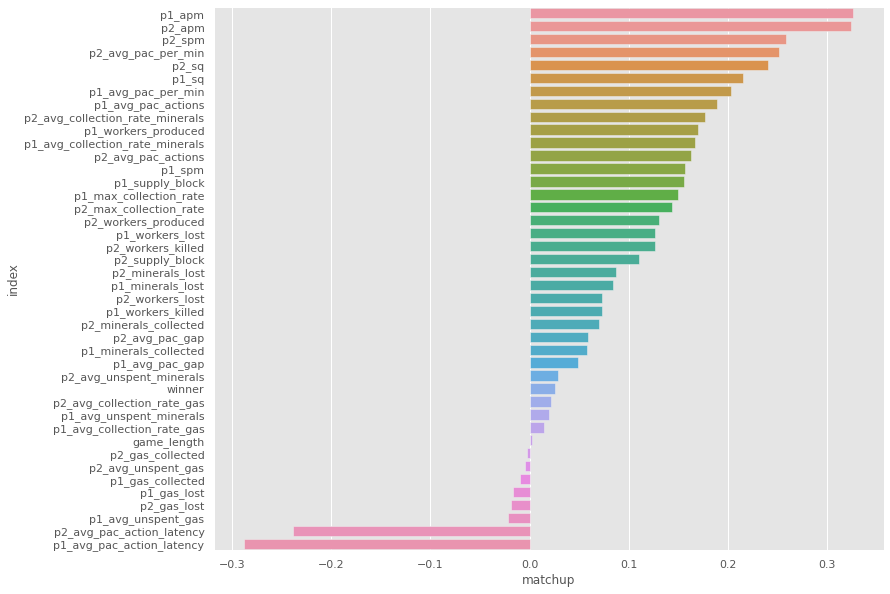

In [ ]:
# Correlation with target
temp_df = train_df.copy()
temp_df['matchup'] = target.copy()
corr_target(temp_df, 'matchup')

### 6. Outlier detection

Removing outlier from comparison between scaled train and test data. If the distance points between train and test higher or lower than treshold (in this case we set 1), then the outlier will be removed

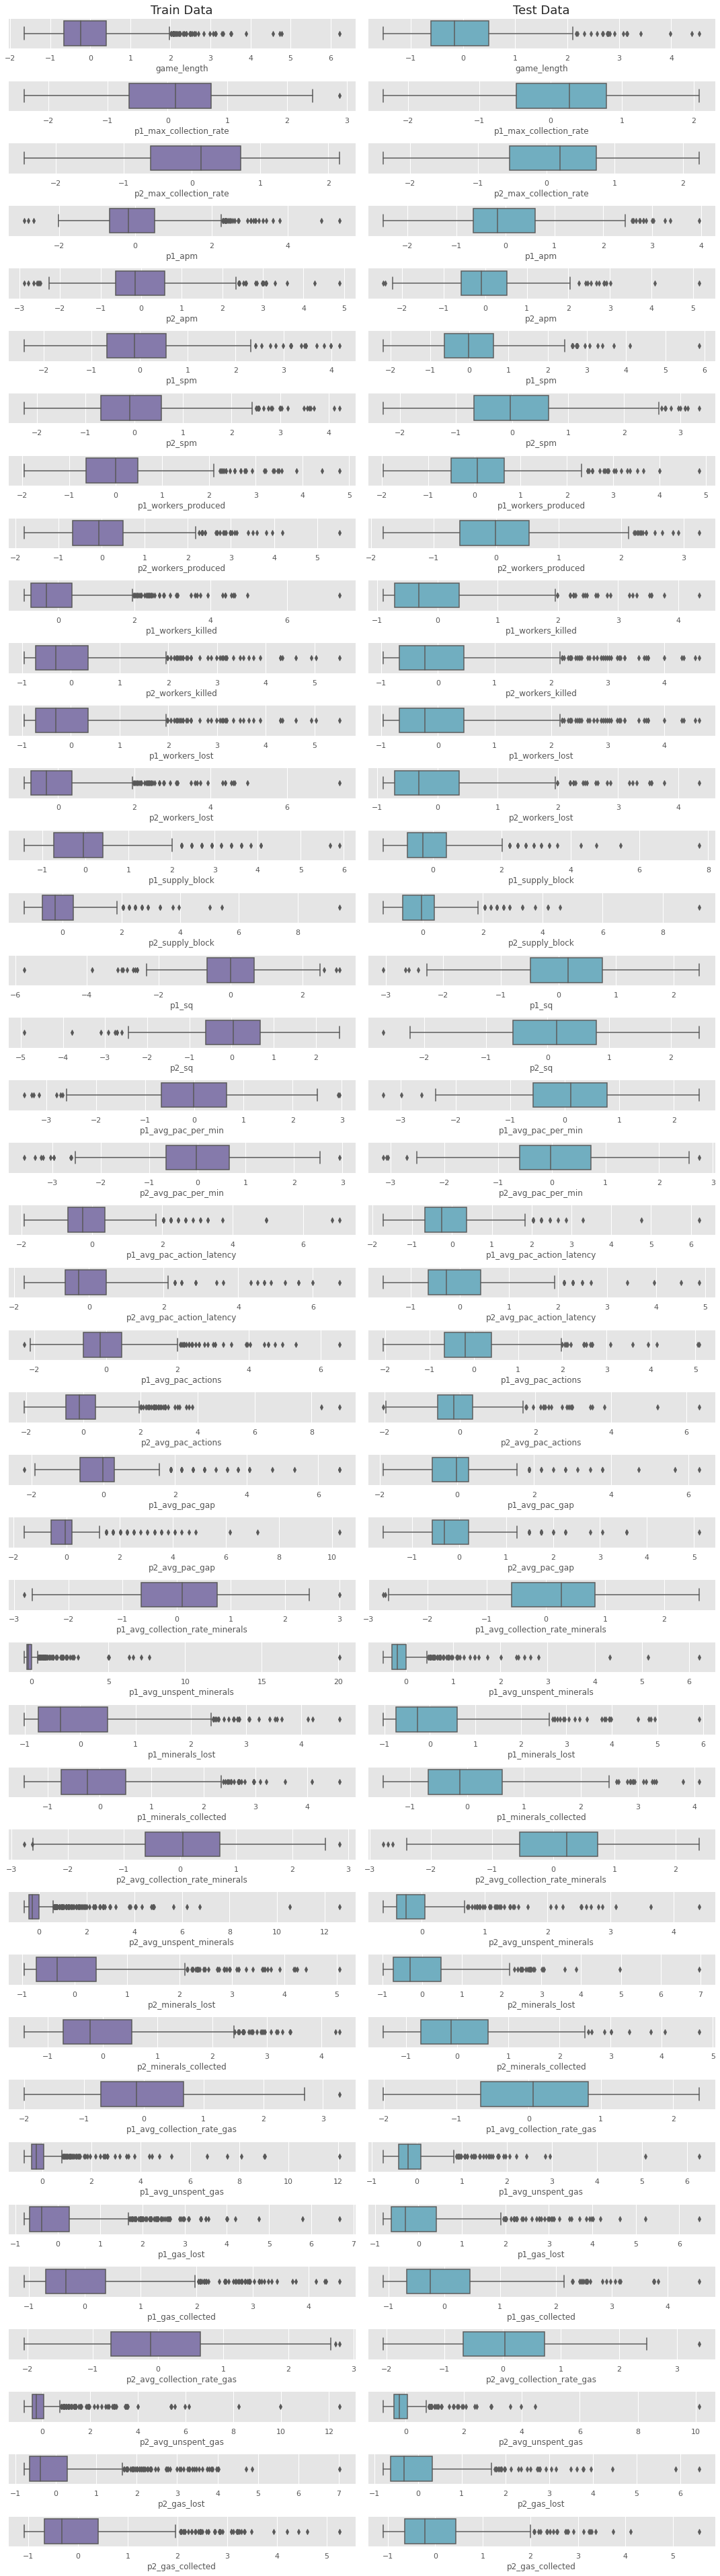

In [ ]:
# Compare outlier between train and test
sc= StandardScaler()
compare1 = train_df.drop('winner', axis=1).select_dtypes('number')
compare2 = test_df.drop('winner', axis=1).select_dtypes('number')
sc.fit(compare1)
compare_boxplot(pd.DataFrame(sc.transform(compare1),columns=compare1.columns), pd.DataFrame(sc.transform(compare2),columns=compare2.columns))

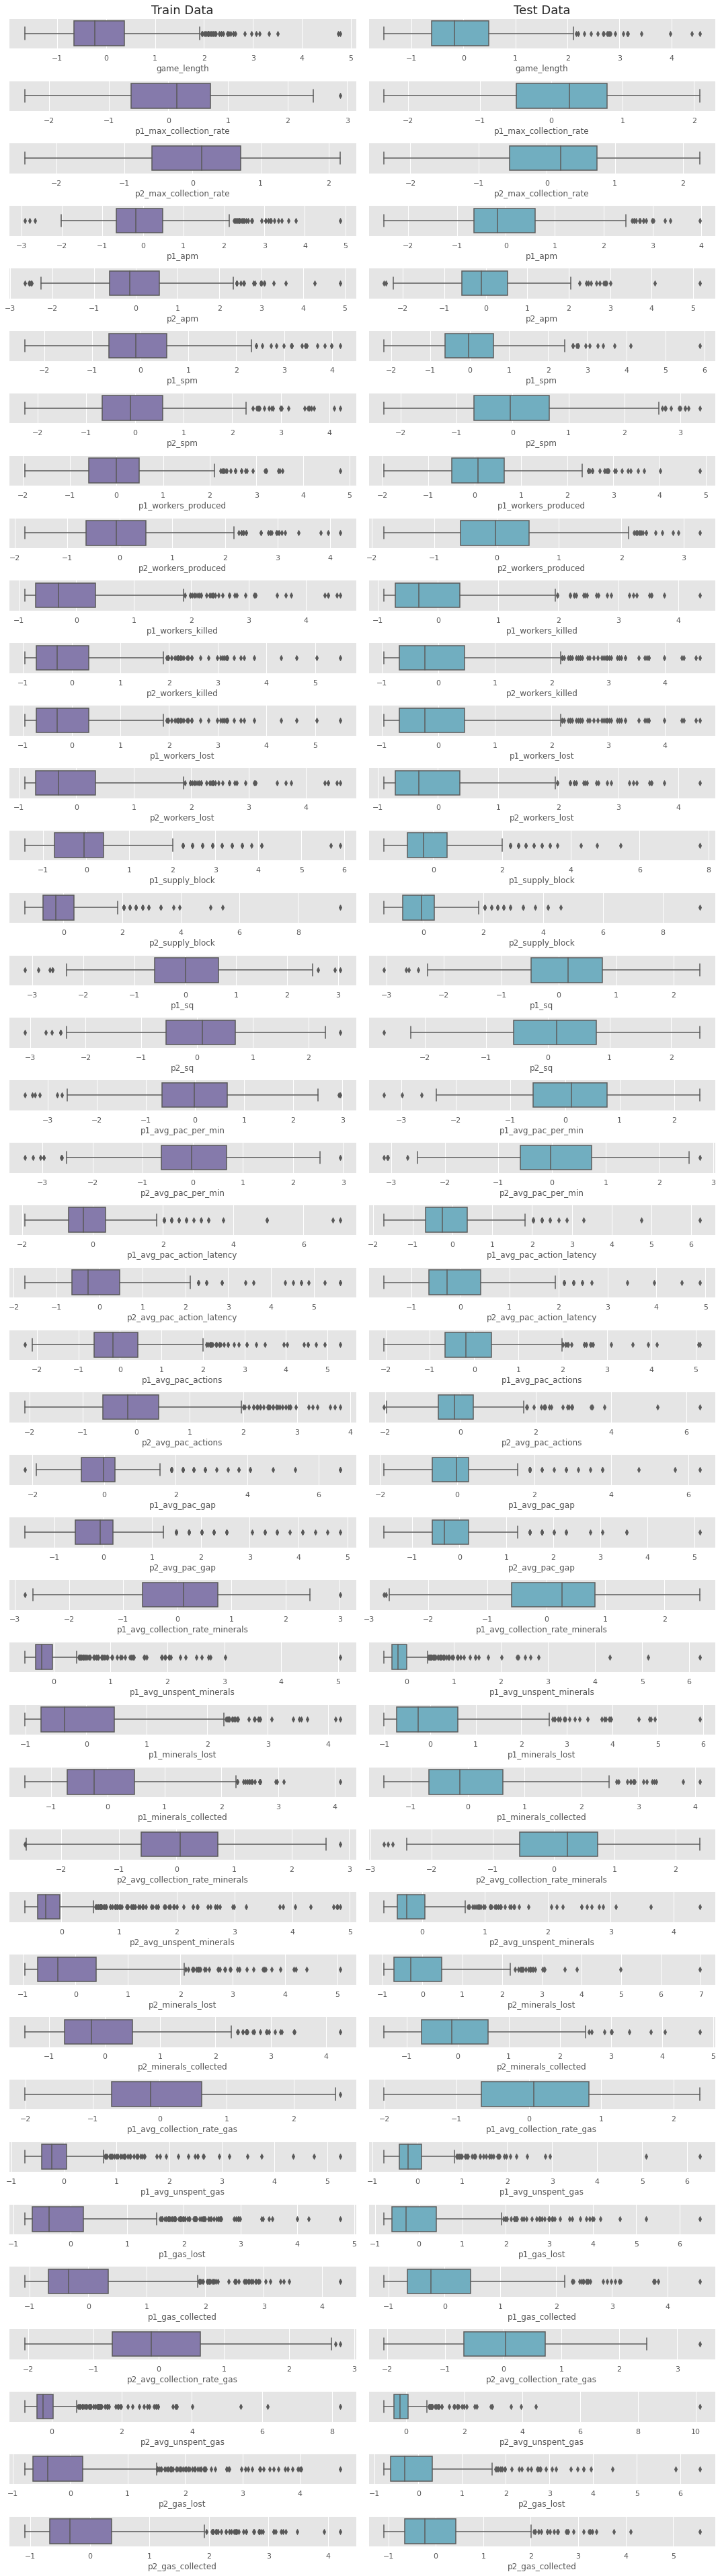

In [ ]:
# Remove outlier on train data
remove_outlier(train_df, test_df, compare=True)

**EDA Explanation**

# Digit Recognition

**Data Preparation**:
* load_data : load data from link
* info_data : info about data
* missing_data : check missing data
* plot_missing_data : plot missing data

**EDA**

* lineplot_data : lineplot between time and col
* pairplot_data : pairplot among features
* dist_data : check distribution on data (can compare with test)
* scatter_target : scatter features with target (regression)
* cat_vs_num : check box/violin/catplot for target vs features
* compare_boxplot : compare boxplot on train and test
* corr_target : correlation feature with target

**Data Manipulation**
* plot_correlation : plot correlation among features
* plot_skew : plot skewness of features
* chi_test : check correlated significance between categorical data
* drop_data : drop data

In [ ]:
train_df = load_data("17Cgnc8-55Xppc4QscSV9T4XYnw6l_5fM")

In [ ]:
target = train_df.label
train_df = train_df.drop("label", axis=1)

In [ ]:
train_df.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 784 columns]

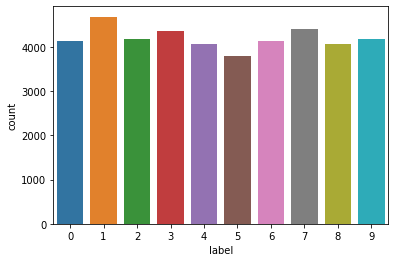

In [ ]:
sns.countplot(target);

In [ ]:
train_df.shape

(42000, 784)

In [ ]:
missing_data(train_df)

Missing columns total: 0/784
Missing columns name: 
Null columns over 25% data: 0 

Series([], dtype: int64)


In [ ]:
X = train_df.values.reshape(-1,28,28,1)
y = target
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.1, random_state=42)

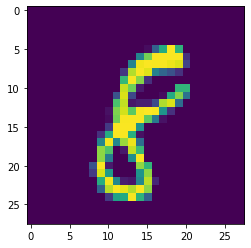

In [ ]:
plt.imshow(X_train[0][:,:,0])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

dummy_y1 = tf.keras.utils.to_categorical(Y_train)
dummy_y2 = tf.keras.utils.to_categorical(Y_val)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
        
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen.fit(X_train)
training_generator = datagen.flow(X_train,dummy_y1, batch_size=86)

with tf.device('/device:GPU:0'):
  history = model.fit(datagen.flow(X_train,dummy_y1, batch_size=86),
                              epochs = 30, validation_data = (X_val,dummy_y2),
                              verbose = 2, callbacks=[learning_rate_reduction,keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,min_delta=0.0001)])

Epoch 1/30
440/440 - 27s - loss: 2.4444 - accuracy: 0.1104 - val_loss: 2.3002 - val_accuracy: 0.1121 - lr: 0.0030 - 27s/epoch - 62ms/step
Epoch 2/30
440/440 - 16s - loss: 2.3016 - accuracy: 0.1106 - val_loss: 2.2999 - val_accuracy: 0.1121 - lr: 0.0030 - 16s/epoch - 36ms/step
Epoch 3/30
440/440 - 18s - loss: 2.3016 - accuracy: 0.1115 - val_loss: 2.3000 - val_accuracy: 0.1121 - lr: 0.0030 - 18s/epoch - 40ms/step
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
440/440 - 17s - loss: 2.3016 - accuracy: 0.1115 - val_loss: 2.3005 - val_accuracy: 0.1121 - lr: 0.0030 - 17s/epoch - 38ms/step
Epoch 5/30
440/440 - 19s - loss: 2.2319 - accuracy: 0.1462 - val_loss: 0.4753 - val_accuracy: 0.8664 - lr: 0.0015 - 19s/epoch - 43ms/step
Epoch 6/30
440/440 - 17s - loss: 0.4528 - accuracy: 0.8571 - val_loss: 0.0833 - val_accuracy: 0.9731 - lr: 0.0015 - 17s/epoch - 39ms/step
Epoch 7/30
440/440 - 17s - loss: 0.2146 - accuracy: 0.9361 - val_loss: 0.0758 - val_accuracy: 0.

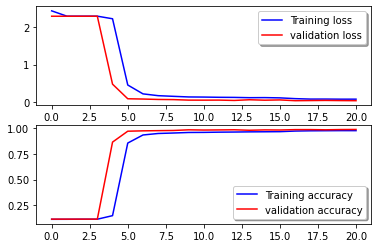

In [ ]:
fig,ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'],color='b',label="Training loss")
ax[0].plot(history.history['val_loss'],color='r',label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'],color='b',label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],color='r',label="validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
res = model.predict(X_val)
# accuracy_score(res, Y_val)
np.argmax(res)

48

In [ ]:
a = []
for i in res:
  a.append(i.argmax())

In [ ]:
accuracy_score(a,Y_val)

0.9902380952380953

In [ ]:
y.shape

(42000,)

In [ ]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

dummy_y = tf.keras.utils.to_categorical(y)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
        
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen.fit(X_train)
training_generator = datagen.flow(X,dummy_y, batch_size=86)

with tf.device('/device:GPU:0'):
  history = model.fit(datagen.flow(X,dummy_y, batch_size=86),
                              epochs = 30,
                              verbose = 2, callbacks=[learning_rate_reduction,keras.callbacks.EarlyStopping(monitor='loss', patience=4,min_delta=0.0001)])

Epoch 1/30
489/489 - 23s - loss: 0.9103 - accuracy: 0.7616 - lr: 0.0030 - 23s/epoch - 47ms/step
Epoch 2/30
489/489 - 17s - loss: 0.2525 - accuracy: 0.9232 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 3/30
489/489 - 17s - loss: 0.2138 - accuracy: 0.9382 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 4/30
489/489 - 17s - loss: 0.2029 - accuracy: 0.9395 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 5/30
489/489 - 17s - loss: 0.2028 - accuracy: 0.9417 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 6/30
489/489 - 17s - loss: 0.1955 - accuracy: 0.9443 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 7/30
489/489 - 18s - loss: 0.1927 - accuracy: 0.9453 - lr: 0.0030 - 18s/epoch - 37ms/step
Epoch 8/30
489/489 - 17s - loss: 0.1956 - accuracy: 0.9445 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 9/30
489/489 - 18s - loss: 0.1966 - accuracy: 0.9451 - lr: 0.0030 - 18s/epoch - 36ms/step
Epoch 10/30
489/489 - 17s - loss: 0.1847 - accuracy: 0.9494 - lr: 0.0030 - 17s/epoch - 36ms/step
Epoch 11/30
489/489 - 17s - loss: 0.192

In [ ]:
test_df = load_data("1w-te9moP9Ng8cNs_dRrzUVKfHO1-EkHx")

In [ ]:
pred = model.predict(test_df.values.reshape(-1,28,28,1))

In [ ]:
final = []
for i in pred:
  final.append(i.argmax())

In [ ]:
test_df["ImageId"] = test_df.index+1

In [ ]:
submission("ImageId", test_df, "Label", final)

ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]